---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 2

---

Please write your full name here
- **Name** : Abdelrahman Muhsen Abdellatif Abdelghany


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from d2l import tensorflow as d2l
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Part 1 Computational Graphs


## Example
Suppose that we have a function of the form: $f(x,y) = \sigma(x) + (x-y)^2$

**SHOW YOUR WORK**

0. **Draw its computational graph with a minimum of 4 operations inside it. Name your intermediate variables and upload a picture of your graph**

- Your Answer:
    - ![Answer](./images/Answer1.png)

1. **Compute the forward path for this function. Use intermediate variables you identified in your graph**

- f --> final output
- Upload a a picture of your graph

- Your Answer:
    - ![Answer](./images/Answer2.png)


2. **Compute the backward path for this function to get:**
$$
\nabla f(x,y) = [ \frac{\partial f}{\partial y}, \frac{\partial f}{\partial x} ]
$$

- Upload a a picture of your graph
- **Use intermediate variables**
- **Write df/dy and df/dx**
- *Hint: Gradients add up at forks. This follows the multivariable chain rule in Calculus, which states that if a variable branches out to different parts, then the gradients that flow back to it will add.*

- Your Answer:
    - ![Answer](./images/Answer3.png)

# this a function to verify part 1 results 

In [2]:
def f_x_y(x,y):
    sigmoid_x=1/(1 +tf.math.exp(-x))
    return sigmoid_x+tf.math.pow((x-y),2)

def verify_part1():
    
    x = tf.Variable(tf.constant(1.0), trainable=True)
    y = tf.Variable(tf.constant(2.0), trainable=True)

    with tf.GradientTape() as tape:
        LOSS = f_x_y(x,y)
    grads = tape.gradient(LOSS,[x,y])
    print(grads)
    print(f_x_y(x,y))
    
verify_part1()    

[<tf.Tensor: shape=(), dtype=float32, numpy=-1.8033881>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>]
tf.Tensor(1.7310586, shape=(), dtype=float32)


# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**

When our inputs consist of $d$ features,
we express our prediction $\hat{y}$ (in general the "hat" symbol denotes estimates) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**C**

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [4]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


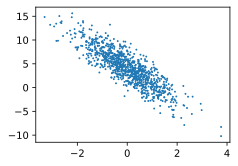

In [6]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not**

In [7]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    dataset=tf.data.Dataset.from_tensor_slices(data_arrays).batch(batch_size)
    if is_train :
        dataset = dataset.shuffle(len(dataset),reshuffle_each_iteration=True) 
        
    return dataset.as_numpy_iterator()

In [8]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)


3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [9]:
### YOUR CODE HERE ###
data_iter.next()

(array([[ 1.3564042e+00, -5.4133564e-01],
        [-1.0421329e+00,  2.0101455e-01],
        [-5.7323533e-01,  9.6179825e-01],
        [ 9.9003547e-01, -1.0166390e+00],
        [-2.7223307e-01, -4.9159122e-01],
        [-8.1928289e-01, -9.0086297e-04],
        [-2.0796096e+00,  8.4328723e-01],
        [ 3.0477965e-01,  2.0460723e-01],
        [ 1.1995399e+00,  2.9454825e+00],
        [-5.4580241e-01, -6.5089208e-01]], dtype=float32),
 array([[ 8.755783  ],
        [ 1.4219627 ],
        [-0.21046364],
        [ 9.629394  ],
        [ 5.3383512 ],
        [ 2.5792086 ],
        [-2.8150222 ],
        [ 4.1173363 ],
        [-3.4104102 ],
        [ 5.3102717 ]], dtype=float32))

4. **Explain what the output shape in the prvious tensors means:**


**Answer:**


two arrays the first one containing features a bartch of size 10 with two features
the second array a batch of size 10 containing corresponding labels


5. **How many TOTAL batches can be generated by **ENTIRE** data_iter ?** --> batches in data

In [10]:
len(labels)/10    

100.0

**Answer:** 100

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [11]:
## YOUR CODE HERE ##
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [12]:
def linreg(X, w, b):  
    """The linear regression model."""
    ## YOUR CODE HERE ##  
    return tf.linalg.matmul(X,w)+b



### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [13]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    ## YOUR CODE HERE ##
    return (y_hat-y.reshape(y_hat.shape))**2/2

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

Note: use assign_sub


In [14]:
def sgd(params, grads, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    ## YOUR CODE HERE ##
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)
    return params
        
    

### Training

10. **Implement the following loop**

* For each epoch :
    * Initialize parameters $(\mathbf{w}, b)$
    * Repeat until done
        * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
    * Print the loss at the end of each epoch

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.


Set the number of epochs `num_epochs` and the learning rate `lr` to 3 and 0.03, respectively.

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [16]:
## YOUR CODE HERE ##
params=[w,b]
for epoch in range(num_epochs):
    print("epoch : "+str(epoch+1))
    data_iter=load_array((features, labels), batch_size)
    for batch in data_iter:
        with tf.GradientTape() as tape:
            LOSS = loss(net(batch[0],params[0],params[1]),batch[1])
        grads = tape.gradient(LOSS,params)
        params=sgd(params, grads, lr, batch_size)
    epochloss = loss(net(batch[0],w,b),batch[1])
    print("loss : " +str(float(tf.reduce_mean(epochloss))))       
            
print(np.transpose(np.array(w)))
print(true_w)
print(b)
print(true_b)



epoch : 1
loss : 0.07214517891407013
epoch : 2
loss : 0.000171059335116297
epoch : 3
loss : 4.0877632272895426e-05
[[ 1.9997225 -3.3987324]]
tf.Tensor([ 2.  -3.4], shape=(2,), dtype=float32)
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199465], dtype=float32)>
4.2


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned**] through our training loop. They should turn out to be very close to each other.


In [17]:
## YOUR CODE HERE ##
print(f'error in estimating w: {true_w - np.transpose(np.array(w))}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [[ 0.00027752 -0.00126767]]
error in estimating b: [0.00053501]


## Part 2  Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [18]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
diabetes_dataset = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [19]:
## YOUR CODE HERE ##

### Look at keys to determine the data
print(diabetes_dataset.keys())


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


3. **Use the key DESCR to understand the dataset**

In [20]:
## YOUR CODE HERE ##
print(diabetes_dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [21]:
### START CODE HERE ### (≈ 2 lines of code)
### END CODE HERE ###
data=diabetes_dataset.data
targets=diabetes_dataset.target

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [22]:
### START CODE HERE ###
data_df = pd.DataFrame(data, columns=["age","sex","bmi","bp", "tc", "ldl", "hdl","tch", "ltg", "glu"])
targets_df = pd.DataFrame(targets, columns=["target"])
print(data_df.describe())
print(targets_df.describe())

### END CODE HERE ###

                age           sex           bmi            bp            tc  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -3.639623e-16  1.309912e-16 -8.013951e-16  1.289818e-16 -9.042540e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123996e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665645e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670611e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564384e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320442e-01  1.539137e-01   

                ldl           hdl           tch           ltg           glu  
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  
mean   1.301121e-16 -4.563971e-16  3.863174e-16 -3.848103e-16 -3.398488e-16  
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761

### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [23]:
np.random.seed(0)
### START CODE HERE ###
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1, random_state=42)

### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Shold we normalize features? WHY?
    - ANSWER: yes ,in theory, data standardization should not affect the performance of a neural network however standardization improves training time. Large input values saturate activation functions such as sigmoid or ReLu(negative input). These types of activation functions feedback small or no gradient at all in the saturated region and therefore slows down training. but in our case we dont need to as in this dataset its already done as Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

7. **normalize the targets using standard normalization**

Hint: Avoid leak between train and test data !!

In [40]:
### START CODE HERE ### (≈ 6 lines of code)
train_targets_mean=np.mean(train_targets)
train_targets_std=np.std(train_targets)
train_targets_normalized=(train_targets-train_targets_mean)/train_targets_std

test_targets_normalized=(test_targets-train_targets_mean)/train_targets_std

### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: 1 neuron to match target shape, activation should be linear

In [41]:
def build_model(input_shape):
    ### START CODE HERE ### ()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(Dense(1,activation='linear'))

    return model

In [42]:
# Print the model summary
input_shape=(train_data.shape[-1],)
model = build_model(input_shape)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1408      
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 1)                

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [43]:
### START CODE HERE ### ()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])


Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 100 epochs, 64 batch size and a validation split of 0.15**

In [44]:
### START CODE HERE ### ()
history = model.fit(train_data, train_targets_normalized, epochs=100, batch_size=64,validation_split = 0.15)

Epoch 1/100
6/6 [==============================] - 1s 54ms/step - loss: 1.0102 - mean_absolute_error: 0.8600 - val_loss: 0.8426 - val_mean_absolute_error: 0.7675
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.9210 - mean_absolute_error: 0.8248 - val_loss: 0.7243 - val_mean_absolute_error: 0.7208
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7224 - mean_absolute_error: 0.7273 - val_loss: 0.5856 - val_mean_absolute_error: 0.6582
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5442 - mean_absolute_error: 0.6045 - val_loss: 0.6334 - val_mean_absolute_error: 0.6279
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4984 - mean_absolute_error: 0.5550 - val_loss: 0.6327 - val_mean_absolute_error: 0.6684
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5283 - mean_absolute_error: 0.5955 - val_loss: 0.5901 - val_mean_absolute_error: 0.6311
Epoch 7/100
6/6 [===========

6/6 [==============================] - 0s 12ms/step - loss: 0.1718 - mean_absolute_error: 0.3240 - val_loss: 0.6979 - val_mean_absolute_error: 0.6704
Epoch 52/100
6/6 [==============================] - 0s 16ms/step - loss: 0.1827 - mean_absolute_error: 0.3308 - val_loss: 0.7418 - val_mean_absolute_error: 0.7047
Epoch 53/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1910 - mean_absolute_error: 0.3472 - val_loss: 0.6691 - val_mean_absolute_error: 0.6555
Epoch 54/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1698 - mean_absolute_error: 0.3147 - val_loss: 0.6567 - val_mean_absolute_error: 0.6436
Epoch 55/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1460 - mean_absolute_error: 0.2883 - val_loss: 0.6519 - val_mean_absolute_error: 0.6548
Epoch 56/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1550 - mean_absolute_error: 0.3050 - val_loss: 0.7062 - val_mean_absolute_error: 0.6885
Epoch 57/100
6/6 [=================

In [45]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets_normalized, verbose=2)

2/2 - 0s - loss: 0.7872 - mean_absolute_error: 0.6736 - 21ms/epoch - 10ms/step


[0.7872320413589478, 0.6736276149749756]

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

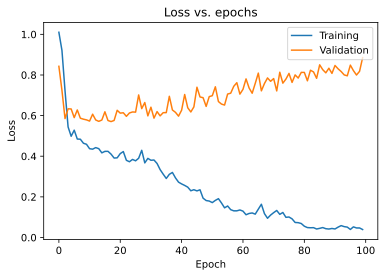

In [47]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - model is too complicated trying to perfectly fit the training data also batch size is too samll
    - overfitting
    - we should first try regulization then maybe Simplifying the model then maybe we need more data finally we can try early stoping if we are fine with these results
    

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

here im gonna try to simplify the model, add regularization as a dropout layer and change batch size to 128 for more smooth curve

In [48]:
#### YOUR CODE HERE


def build_model(input_shape):
    ### START CODE HERE ### ()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(Dense(1,activation='linear'))

    return model
input_shape=(train_data.shape[-1],)
model = build_model(input_shape)
print(model.summary())
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(train_data, train_targets_normalized, epochs=100, batch_size=128,validation_split = 0.15)
model.evaluate(test_data, test_targets_normalized, verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                704       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
3/3 [==============================

Epoch 45/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4801 - mean_absolute_error: 0.5621 - val_loss: 0.5754 - val_mean_absolute_error: 0.6115
Epoch 46/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4736 - mean_absolute_error: 0.5605 - val_loss: 0.5755 - val_mean_absolute_error: 0.6114
Epoch 47/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4761 - mean_absolute_error: 0.5542 - val_loss: 0.5769 - val_mean_absolute_error: 0.6124
Epoch 48/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4942 - mean_absolute_error: 0.5702 - val_loss: 0.5743 - val_mean_absolute_error: 0.6091
Epoch 49/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4650 - mean_absolute_error: 0.5563 - val_loss: 0.5729 - val_mean_absolute_error: 0.6057
Epoch 50/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4599 - mean_absolute_error: 0.5522 - val_loss: 0.5726 - val_mean_absolute_error: 0.6064
Epoch 51/100
3/3 [====

3/3 [==============================] - 0s 15ms/step - loss: 0.4558 - mean_absolute_error: 0.5542 - val_loss: 0.5646 - val_mean_absolute_error: 0.6067
Epoch 96/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4443 - mean_absolute_error: 0.5331 - val_loss: 0.5648 - val_mean_absolute_error: 0.6072
Epoch 97/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4363 - mean_absolute_error: 0.5295 - val_loss: 0.5649 - val_mean_absolute_error: 0.6070
Epoch 98/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4440 - mean_absolute_error: 0.5370 - val_loss: 0.5643 - val_mean_absolute_error: 0.6078
Epoch 99/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4386 - mean_absolute_error: 0.5314 - val_loss: 0.5637 - val_mean_absolute_error: 0.6080
Epoch 100/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4514 - mean_absolute_error: 0.5406 - val_loss: 0.5635 - val_mean_absolute_error: 0.6082
2/2 - 0s - loss: 0.4090 - mean_abs

[0.4090358316898346, 0.5023708939552307]

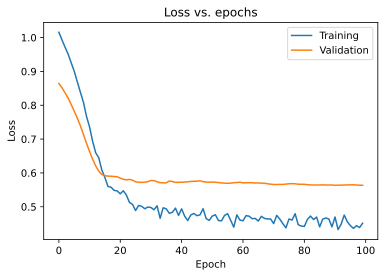

In [49]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with. 
The data will have 2 features and 3 target classes --> multiclass classification problem

In [33]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
    
    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


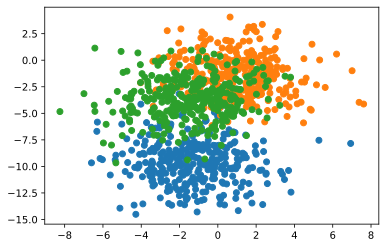

In [34]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


In [35]:
y_train.shape

(500, 3)

- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [36]:
def build_model(input_shape,Lr):
    
    ##### YOUR CODE HERE
    # define model  
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(50, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
    model.add(Dense(3,activation=tf.keras.activations.softmax))
              
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=Lr, momentum=0.9), metrics=['Accuracy'])

    print(model.summary())

    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [37]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch,Lr):
    ##### YOUR CODE HERE
    # build model
    model=build_model(input_shape=X_train.shape[-1],Lr=Lr)
    # fit model
    history = model.fit(X_train, y_train, epochs=125, batch_size=n_batch,validation_data=(X_test, y_test))

    
    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [38]:
### START CODE HERE ### 
batch_size=1
learning_rate=0.01
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)
###### END CODE HERE

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                150       
                                                                 
 dense_12 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
500/500 [==============================] - 2s 4ms/step - loss: 2.2584 - Accuracy: 0.4820 - val_loss: 0.9776 - val_Accuracy: 0.4980
Epoch 2/125
500/500 [==============================] - 2s 4ms/step - loss: 1.0435 - Accuracy: 0.5040 - val_loss: 1.0281 - val_Accuracy: 0.6060
Epoch 3/125
500/500 [==============================] - 2s 4ms/step - loss: 1.0918 - Accuracy: 0.4680 - val_loss: 1.0252 - val_Accuracy: 0.4720
Epoch 4/125
500/50

Epoch 110/125
500/500 [==============================] - 2s 4ms/step - loss: 0.8298 - Accuracy: 0.6540 - val_loss: 0.7736 - val_Accuracy: 0.6700
Epoch 111/125
500/500 [==============================] - 2s 4ms/step - loss: 0.8810 - Accuracy: 0.6000 - val_loss: 0.8539 - val_Accuracy: 0.6140
Epoch 112/125
500/500 [==============================] - 2s 4ms/step - loss: 0.8417 - Accuracy: 0.6260 - val_loss: 0.7300 - val_Accuracy: 0.6920
Epoch 113/125
500/500 [==============================] - 2s 4ms/step - loss: 0.8448 - Accuracy: 0.6100 - val_loss: 0.8090 - val_Accuracy: 0.6800
Epoch 114/125
500/500 [==============================] - 2s 4ms/step - loss: 0.9207 - Accuracy: 0.5300 - val_loss: 1.0036 - val_Accuracy: 0.4780
Epoch 115/125
500/500 [==============================] - 2s 4ms/step - loss: 0.9803 - Accuracy: 0.5040 - val_loss: 0.9267 - val_Accuracy: 0.5760
Epoch 116/125
500/500 [==============================] - 2s 4ms/step - loss: 0.9066 - Accuracy: 0.5960 - val_loss: 0.6936 - val_Ac

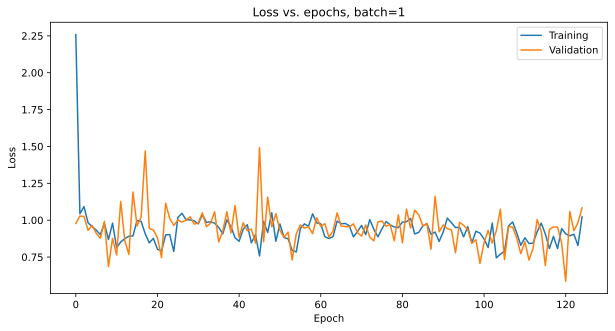

In [39]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: learning rate is too big for a batch size of 1 i guess it got stuck in a local minimum 
    
- Change learning rate to make this curve better

In [40]:
### Your answer
batch_size=1
learning_rate=0.001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 50)                150       
                                                                 
 dense_14 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
500/500 [==============================] - 2s 4ms/step - loss: 1.8899 - Accuracy: 0.6020 - val_loss: 0.8438 - val_Accuracy: 0.6820
Epoch 2/125
500/500 [==============================] - 2s 4ms/step - loss: 0.8586 - Accuracy: 0.6780 - val_loss: 0.6127 - val_Accuracy: 0.7780
Epoch 3/125
500/500 [==============================] - 2s 4ms/step - loss: 0.7311 - Accuracy: 0.6980 - val_loss: 0.6747 - val_Accuracy: 0.7320
Epoch 4/125
500/50

Epoch 110/125
500/500 [==============================] - 2s 4ms/step - loss: 0.3939 - Accuracy: 0.8140 - val_loss: 0.5027 - val_Accuracy: 0.8140
Epoch 111/125
500/500 [==============================] - 2s 4ms/step - loss: 0.3940 - Accuracy: 0.8380 - val_loss: 0.4576 - val_Accuracy: 0.8220
Epoch 112/125
500/500 [==============================] - 2s 5ms/step - loss: 0.3969 - Accuracy: 0.8240 - val_loss: 0.4554 - val_Accuracy: 0.8160
Epoch 113/125
500/500 [==============================] - 2s 4ms/step - loss: 0.4033 - Accuracy: 0.8280 - val_loss: 0.4420 - val_Accuracy: 0.8260
Epoch 114/125
500/500 [==============================] - 2s 4ms/step - loss: 0.4000 - Accuracy: 0.8140 - val_loss: 0.4867 - val_Accuracy: 0.7960
Epoch 115/125
500/500 [==============================] - 2s 4ms/step - loss: 0.3880 - Accuracy: 0.8360 - val_loss: 0.4713 - val_Accuracy: 0.8260
Epoch 116/125
500/500 [==============================] - 2s 5ms/step - loss: 0.4049 - Accuracy: 0.8220 - val_loss: 0.4526 - val_Ac

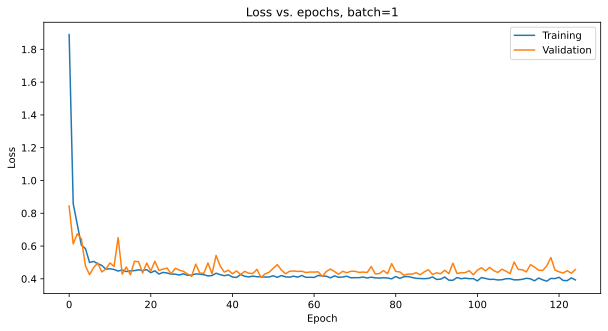

In [41]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [42]:
### START CODE HERE ### 
batch_size=16
learning_rate=0.001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)

###### END CODE HERE

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                150       
                                                                 
 dense_16 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
32/32 [==============================] - 1s 8ms/step - loss: 1.5175 - Accuracy: 0.4980 - val_loss: 0.8811 - val_Accuracy: 0.6280
Epoch 2/125
32/32 [==============================] - 0s 6ms/step - loss: 0.9219 - Accuracy: 0.5800 - val_loss: 0.8960 - val_Accuracy: 0.6440
Epoch 3/125
32/32 [==============================] - 0s 6ms/step - loss: 0.8138 - Accuracy: 0.6320 - val_loss: 0.6462 - val_Accuracy: 0.6940
Epoch 4/125
32/32 [=====

Epoch 54/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4802 - Accuracy: 0.7920 - val_loss: 0.4581 - val_Accuracy: 0.8240
Epoch 55/125
32/32 [==============================] - 0s 6ms/step - loss: 0.4768 - Accuracy: 0.7940 - val_loss: 0.4598 - val_Accuracy: 0.8280
Epoch 56/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4865 - Accuracy: 0.7940 - val_loss: 0.4635 - val_Accuracy: 0.8060
Epoch 57/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4857 - Accuracy: 0.7940 - val_loss: 0.4626 - val_Accuracy: 0.8040
Epoch 58/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4910 - Accuracy: 0.7920 - val_loss: 0.4676 - val_Accuracy: 0.8300
Epoch 59/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4622 - Accuracy: 0.8020 - val_loss: 0.4651 - val_Accuracy: 0.8120
Epoch 60/125
32/32 [==============================] - 0s 5ms/step - loss: 0.4972 - Accuracy: 0.7820 - val_loss: 0.4454 - val_Accuracy: 0.8180
Epoch 

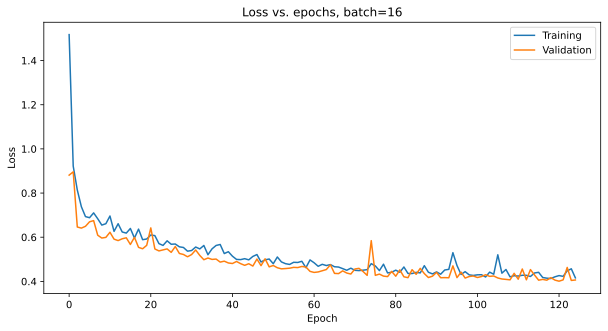

In [43]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [44]:
### START CODE HERE ### 
batch_size=128
learning_rate=0.001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)
###### END CODE HERE

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 50)                150       
                                                                 
 dense_18 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
4/4 [==============================] - 0s 42ms/step - loss: 5.4826 - Accuracy: 0.1840 - val_loss: 2.9875 - val_Accuracy: 0.3880
Epoch 2/125
4/4 [==============================] - 0s 11ms/step - loss: 3.0829 - Accuracy: 0.3760 - val_loss: 3.0797 - val_Accuracy: 0.3820
Epoch 3/125
4/4 [==============================] - 0s 11ms/step - loss: 2.6672 - Accuracy: 0.3940 - val_loss: 2.6005 - val_Accuracy: 0.3200
Epoch 4/125
4/4 [==========

4/4 [==============================] - 0s 13ms/step - loss: 0.6029 - Accuracy: 0.7000 - val_loss: 0.5878 - val_Accuracy: 0.7400
Epoch 113/125
4/4 [==============================] - 0s 13ms/step - loss: 0.6034 - Accuracy: 0.6940 - val_loss: 0.5875 - val_Accuracy: 0.7460
Epoch 114/125
4/4 [==============================] - 0s 13ms/step - loss: 0.6011 - Accuracy: 0.7040 - val_loss: 0.5879 - val_Accuracy: 0.7480
Epoch 115/125
4/4 [==============================] - 0s 12ms/step - loss: 0.6008 - Accuracy: 0.7020 - val_loss: 0.5848 - val_Accuracy: 0.7420
Epoch 116/125
4/4 [==============================] - 0s 12ms/step - loss: 0.6000 - Accuracy: 0.7000 - val_loss: 0.5843 - val_Accuracy: 0.7420
Epoch 117/125
4/4 [==============================] - 0s 12ms/step - loss: 0.5995 - Accuracy: 0.7020 - val_loss: 0.5867 - val_Accuracy: 0.7460
Epoch 118/125
4/4 [==============================] - 0s 12ms/step - loss: 0.5990 - Accuracy: 0.7080 - val_loss: 0.5831 - val_Accuracy: 0.7440
Epoch 119/125
4/4 [=

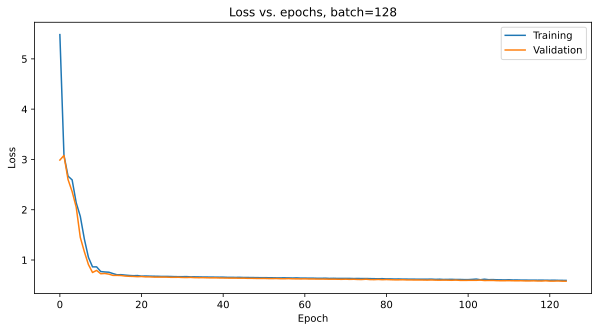

In [45]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [46]:
### START CODE HERE ### 
batch_size=len(X_train)
learning_rate=0.001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)
###### END CODE HERE

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 50)                150       
                                                                 
 dense_20 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
1/1 [==============================] - 0s 377ms/step - loss: 3.6011 - Accuracy: 0.3140 - val_loss: 3.3587 - val_Accuracy: 0.2760
Epoch 2/125
1/1 [==============================] - 0s 25ms/step - loss: 3.1970 - Accuracy: 0.3080 - val_loss: 2.8192 - val_Accuracy: 0.3200
Epoch 3/125
1/1 [==============================] - 0s 23ms/step - loss: 2.5839 - Accuracy: 0.3080 - val_loss: 2.4587 - val_Accuracy: 0.3700
Epoch 4/125
1/1 [=========

1/1 [==============================] - 0s 24ms/step - loss: 0.6829 - Accuracy: 0.6740 - val_loss: 0.6393 - val_Accuracy: 0.7040
Epoch 113/125
1/1 [==============================] - 0s 26ms/step - loss: 0.6822 - Accuracy: 0.6720 - val_loss: 0.6387 - val_Accuracy: 0.7060
Epoch 114/125
1/1 [==============================] - 0s 24ms/step - loss: 0.6816 - Accuracy: 0.6720 - val_loss: 0.6381 - val_Accuracy: 0.7040
Epoch 115/125
1/1 [==============================] - 0s 24ms/step - loss: 0.6810 - Accuracy: 0.6700 - val_loss: 0.6375 - val_Accuracy: 0.7060
Epoch 116/125
1/1 [==============================] - 0s 24ms/step - loss: 0.6803 - Accuracy: 0.6720 - val_loss: 0.6368 - val_Accuracy: 0.7060
Epoch 117/125
1/1 [==============================] - 0s 25ms/step - loss: 0.6797 - Accuracy: 0.6720 - val_loss: 0.6362 - val_Accuracy: 0.7060
Epoch 118/125
1/1 [==============================] - 0s 25ms/step - loss: 0.6791 - Accuracy: 0.6740 - val_loss: 0.6356 - val_Accuracy: 0.7060
Epoch 119/125
1/1 [=

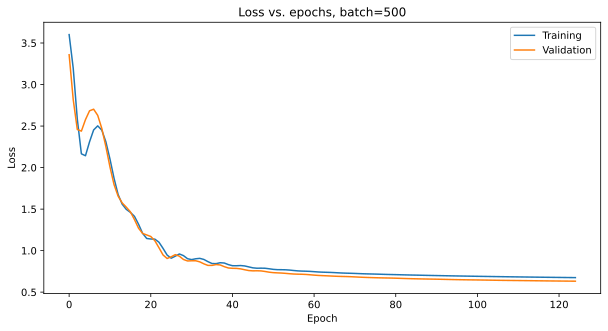

In [47]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:** as the batch size gets bigger fluctuations gets lower as we compute the loss less, and as batch size gets bigger learning gets slower 

#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [48]:
#def build_model(lr):
    
    ##### YOUR CODE HERE
    # define model

    
    # compile model
    
    #return model
    
#already added it in cells above

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [49]:
### START CODE HERE ### 
batch_size=64
learning_rate=0.00001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)


# Print the model summary


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                150       
                                                                 
 dense_22 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 24ms/step - loss: 1.1841 - Accuracy: 0.4300 - val_loss: 1.2152 - val_Accuracy: 0.4260
Epoch 2/125
8/8 [==============================] - 0s 9ms/step - loss: 1.1792 - Accuracy: 0.4300 - val_loss: 1.2090 - val_Accuracy: 0.4260
Epoch 3/125
8/8 [==============================] - 0s 10ms/step - loss: 1.1721 - Accuracy: 0.4300 - val_loss: 1.2017 - val_Accuracy: 0.4260
Epoch 4/125
8/8 [===========

8/8 [==============================] - 0s 10ms/step - loss: 0.8621 - Accuracy: 0.5480 - val_loss: 0.8202 - val_Accuracy: 0.5300
Epoch 113/125
8/8 [==============================] - 0s 9ms/step - loss: 0.8612 - Accuracy: 0.5500 - val_loss: 0.8188 - val_Accuracy: 0.5300
Epoch 114/125
8/8 [==============================] - 0s 9ms/step - loss: 0.8602 - Accuracy: 0.5520 - val_loss: 0.8175 - val_Accuracy: 0.5360
Epoch 115/125
8/8 [==============================] - 0s 9ms/step - loss: 0.8592 - Accuracy: 0.5520 - val_loss: 0.8163 - val_Accuracy: 0.5340
Epoch 116/125
8/8 [==============================] - 0s 9ms/step - loss: 0.8583 - Accuracy: 0.5540 - val_loss: 0.8150 - val_Accuracy: 0.5360
Epoch 117/125
8/8 [==============================] - 0s 10ms/step - loss: 0.8575 - Accuracy: 0.5580 - val_loss: 0.8138 - val_Accuracy: 0.5420
Epoch 118/125
8/8 [==============================] - 0s 10ms/step - loss: 0.8565 - Accuracy: 0.5600 - val_loss: 0.8126 - val_Accuracy: 0.5440
Epoch 119/125
8/8 [=====

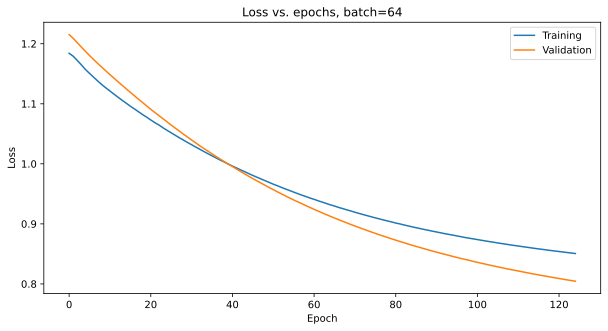

In [50]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [51]:
### START CODE HERE ### ()
batch_size=64
learning_rate=0.001
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 50)                150       
                                                                 
 dense_24 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 25ms/step - loss: 2.2796 - Accuracy: 0.4180 - val_loss: 1.5724 - val_Accuracy: 0.4600
Epoch 2/125
8/8 [==============================] - 0s 10ms/step - loss: 1.2954 - Accuracy: 0.4240 - val_loss: 0.9893 - val_Accuracy: 0.4700
Epoch 3/125
8/8 [==============================] - 0s 10ms/step - loss: 0.8666 - Accuracy: 0.5480 - val_loss: 0.7233 - val_Accuracy: 0.6880
Epoch 4/125
8/8 [==========

8/8 [==============================] - 0s 8ms/step - loss: 0.5630 - Accuracy: 0.7260 - val_loss: 0.5440 - val_Accuracy: 0.7960
Epoch 113/125
8/8 [==============================] - 0s 9ms/step - loss: 0.5705 - Accuracy: 0.7400 - val_loss: 0.5339 - val_Accuracy: 0.7640
Epoch 114/125
8/8 [==============================] - 0s 9ms/step - loss: 0.5491 - Accuracy: 0.7560 - val_loss: 0.5359 - val_Accuracy: 0.8020
Epoch 115/125
8/8 [==============================] - 0s 9ms/step - loss: 0.5489 - Accuracy: 0.7480 - val_loss: 0.5278 - val_Accuracy: 0.7800
Epoch 116/125
8/8 [==============================] - 0s 8ms/step - loss: 0.5458 - Accuracy: 0.7540 - val_loss: 0.5288 - val_Accuracy: 0.7920
Epoch 117/125
8/8 [==============================] - 0s 8ms/step - loss: 0.5524 - Accuracy: 0.7480 - val_loss: 0.5311 - val_Accuracy: 0.8040
Epoch 118/125
8/8 [==============================] - 0s 8ms/step - loss: 0.5485 - Accuracy: 0.7540 - val_loss: 0.5286 - val_Accuracy: 0.8080
Epoch 119/125
8/8 [========

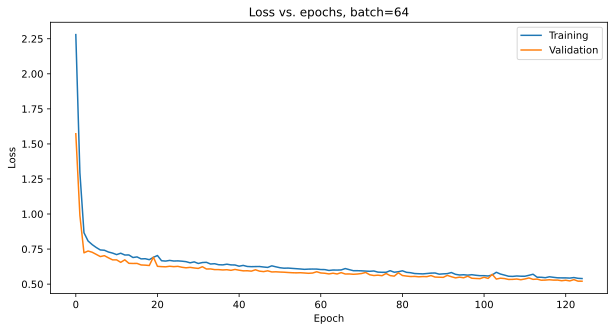

In [52]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [53]:
### START CODE HERE ### ()
batch_size=64
learning_rate=0.1
history=fit_model(X_train, y_train, X_test, y_test, batch_size,learning_rate)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 50)                150       
                                                                 
 dense_26 (Dense)            (None, 3)                 153       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/125
8/8 [==============================] - 0s 23ms/step - loss: 13.9549 - Accuracy: 0.3960 - val_loss: 7.3351 - val_Accuracy: 0.4740
Epoch 2/125
8/8 [==============================] - 0s 10ms/step - loss: 8.5081 - Accuracy: 0.5840 - val_loss: 10.0802 - val_Accuracy: 0.6900
Epoch 3/125
8/8 [==============================] - 0s 10ms/step - loss: 3.8298 - Accuracy: 0.7160 - val_loss: 0.8428 - val_Accuracy: 0.7840
Epoch 4/125
8/8 [========

8/8 [==============================] - 0s 10ms/step - loss: 0.3837 - Accuracy: 0.8280 - val_loss: 0.4378 - val_Accuracy: 0.8180
Epoch 113/125
8/8 [==============================] - 0s 10ms/step - loss: 0.4052 - Accuracy: 0.8200 - val_loss: 0.4682 - val_Accuracy: 0.8120
Epoch 114/125
8/8 [==============================] - 0s 10ms/step - loss: 0.4104 - Accuracy: 0.8140 - val_loss: 0.4288 - val_Accuracy: 0.8240
Epoch 115/125
8/8 [==============================] - 0s 10ms/step - loss: 0.4213 - Accuracy: 0.8160 - val_loss: 0.4266 - val_Accuracy: 0.8260
Epoch 116/125
8/8 [==============================] - 0s 10ms/step - loss: 0.3970 - Accuracy: 0.8260 - val_loss: 0.4354 - val_Accuracy: 0.8220
Epoch 117/125
8/8 [==============================] - 0s 10ms/step - loss: 0.4201 - Accuracy: 0.8140 - val_loss: 0.4883 - val_Accuracy: 0.8040
Epoch 118/125
8/8 [==============================] - 0s 10ms/step - loss: 0.4824 - Accuracy: 0.7940 - val_loss: 0.4610 - val_Accuracy: 0.8100
Epoch 119/125
8/8 [=

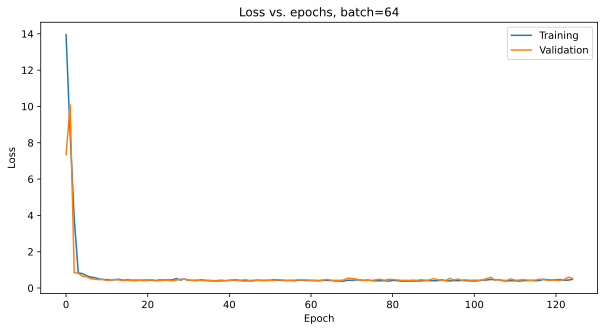

In [54]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**

**Answer:** as learning rate gets smaller learning will take more epochs and when learning rate gets bigger we might get stuck in a local minimum and never converge 